In [1]:
!pip install fastai==2.7.9
!pip install fastkaggle==0.0.7
!pip install fasterai==0.1.11
!pip install ipython-autotime==0.3.1
!pip install torch==1.12.1
!pip install fairscale==0.4.6
%load_ext autotime

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.11
    Uninstalling fastai-2.7.11:
      Successfully uninstalled fastai-2.7.11
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 774.0 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0
    Uninstalling torch-1.12.0:
      Successfully uninstalled torch-1.12.0
/bin/bash: /opt/conda/lib/libtin

In [2]:
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
from fastai.fp16_utils import *

from fasterai.sparse.all import *
from fasterai.core.criteria import *
from fasterai.regularize.all import *

from fastkaggle import *

from fairscale.experimental.tooling.layer_memory_tracker import LayerwiseMemoryTracker

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle as pkl

from test_roc_prc import ROC, PRC
import gc

import inspect


set_seed(42)

/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


time: 4.27 s (started: 2023-05-01 07:55:45 +00:00)


In [3]:
@patch
def custom_plot_losses(self: Recorder, skip_start=5, with_valid=True, filename="temp.txt"):
    fig2 = plt.figure("Figure 2")

    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_loss') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train loss')
    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_loss') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid loss')
        plt.legend()

    
@patch
def custom_plot_values(self: Recorder, skip_start=5, with_valid=True):
    fig3 = plt.figure("Figure 3")
    
    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_accuracy') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train accuracy')

    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_accuracy') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid accuracy')
        plt.legend()

time: 2.54 ms (started: 2023-05-01 07:55:50 +00:00)


In [4]:
comp = 'paddy-diseases/paddy-diseases'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

time: 17.4 s (started: 2023-05-01 07:55:50 +00:00)


In [5]:
dls = ImageDataLoaders.from_folder(path/"train", 
                                   valid_pct=0.25, 
                                   item_tfms=Resize(256), 
                                   batch_tfms=aug_transforms(   size=64, 
                                                                min_scale=0.75,
                                                                max_rotate=10., 
                                                                min_zoom=0.8, 
                                                                max_zoom=1.2, 
                                                            
                                                            ), 
                                   bs=32//2)

time: 6.37 s (started: 2023-05-01 07:56:07 +00:00)


In [6]:
sp_cb=[
      GradientAccumulation(32), 
      SparsifyCallback(sparsity=25, 
                         granularity='filter', 
                         context='local', 
                         criteria=large_final, 
                         schedule=one_cycle),


]

time: 976 µs (started: 2023-05-01 07:56:13 +00:00)


In [7]:
model = vgg16_bn(num_classes=10)


time: 3.23 s (started: 2023-05-01 07:56:13 +00:00)


In [8]:
learn = Learner(dls, 
                model, 
                metrics=[accuracy,
                         error_rate,
                        ]).to_fp16()
learn.unfreeze()
learn.recorder.train_metrics = True
learn.path = Path("/kaggle/working/")

time: 22.8 ms (started: 2023-05-01 07:56:17 +00:00)


Pruning of filter until a sparsity of [25]%
Saving Weights at epoch 0


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,2.231874,0.174519,0.825481,2.066468,0.276923,0.723077,02:18
1,2.158582,0.218750,0.781250,2.017792,0.292788,0.707212,02:11
2,2.062152,0.240705,0.759295,1.985882,0.298558,0.701442,02:12
3,2.067952,0.260577,0.739423,1.943030,0.330769,0.669231,01:54
4,2.029466,0.276282,0.723718,1.933639,0.320192,0.679808,01:44
5,1.998724,0.285577,0.714423,1.851697,0.365385,0.634615,02:13
6,1.927547,0.307051,0.692949,1.805246,0.369712,0.630288,02:13
7,1.885810,0.321635,0.678365,1.762237,0.401923,0.598077,01:48
8,1.871268,0.341506,0.658494,1.673825,0.423077,0.576923,01:23
9,1.817276,0.375321,0.624680,1.642437,0.443269,0.556731,01:22


Sparsity at the end of epoch 0: [0.07]%
Sparsity at the end of epoch 1: [0.08]%
Sparsity at the end of epoch 2: [0.09]%
Sparsity at the end of epoch 3: [0.11]%
Sparsity at the end of epoch 4: [0.12]%
Sparsity at the end of epoch 5: [0.14]%
Sparsity at the end of epoch 6: [0.16]%
Sparsity at the end of epoch 7: [0.19]%
Sparsity at the end of epoch 8: [0.22]%
Sparsity at the end of epoch 9: [0.25]%
Sparsity at the end of epoch 10: [0.29]%
Sparsity at the end of epoch 11: [0.33]%
Sparsity at the end of epoch 12: [0.38]%
Sparsity at the end of epoch 13: [0.43]%
Sparsity at the end of epoch 14: [0.5]%
Sparsity at the end of epoch 15: [0.57]%
Sparsity at the end of epoch 16: [0.65]%
Sparsity at the end of epoch 17: [0.75]%
Sparsity at the end of epoch 18: [0.86]%
Sparsity at the end of epoch 19: [0.98]%
Sparsity at the end of epoch 20: [1.12]%
Sparsity at the end of epoch 21: [1.28]%
Sparsity at the end of epoch 22: [1.46]%
Sparsity at the end of epoch 23: [1.67]%
Sparsity at the end of epoc

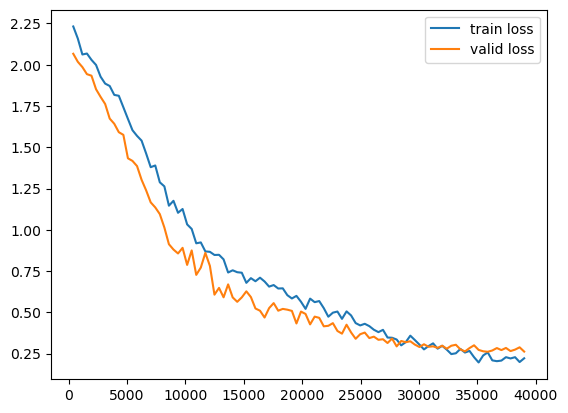

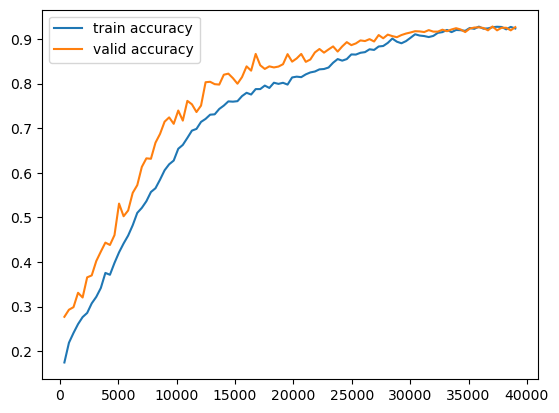

time: 2h 29min 43s (started: 2023-05-01 07:56:17 +00:00)


In [9]:
learn.fit_one_cycle(100, 3e-5, cbs=sp_cb)
                    
learn.recorder.custom_plot_losses()
learn.recorder.custom_plot_values()

In [29]:
learn.export(Path("/kaggle/working/VGG16_bn_native_fp16_accum2_sparse25.pkl"))

time: 3.19 s (started: 2023-05-01 10:35:31 +00:00)


In [11]:
learner= load_learner(Path("/kaggle/working/VGG16_bn_native_fp16_accum2_sparse25.pkl"))

time: 414 ms (started: 2023-05-01 10:26:02 +00:00)


In [12]:
tst_files = get_image_files(path/'test').sorted()
tst_dl = dls.test_dl(tst_files, with_labels=True,)


time: 6.76 s (started: 2023-05-01 10:26:02 +00:00)


In [13]:
preds, _, idx = learner.get_preds(dl=tst_dl, with_decoded=True)
y_score = preds.numpy()

time: 1min 30s (started: 2023-05-01 10:26:09 +00:00)


In [14]:
y_onehot_test = (y_score == y_score.max(axis=1, keepdims=1)).astype(int)

time: 966 µs (started: 2023-05-01 10:27:39 +00:00)


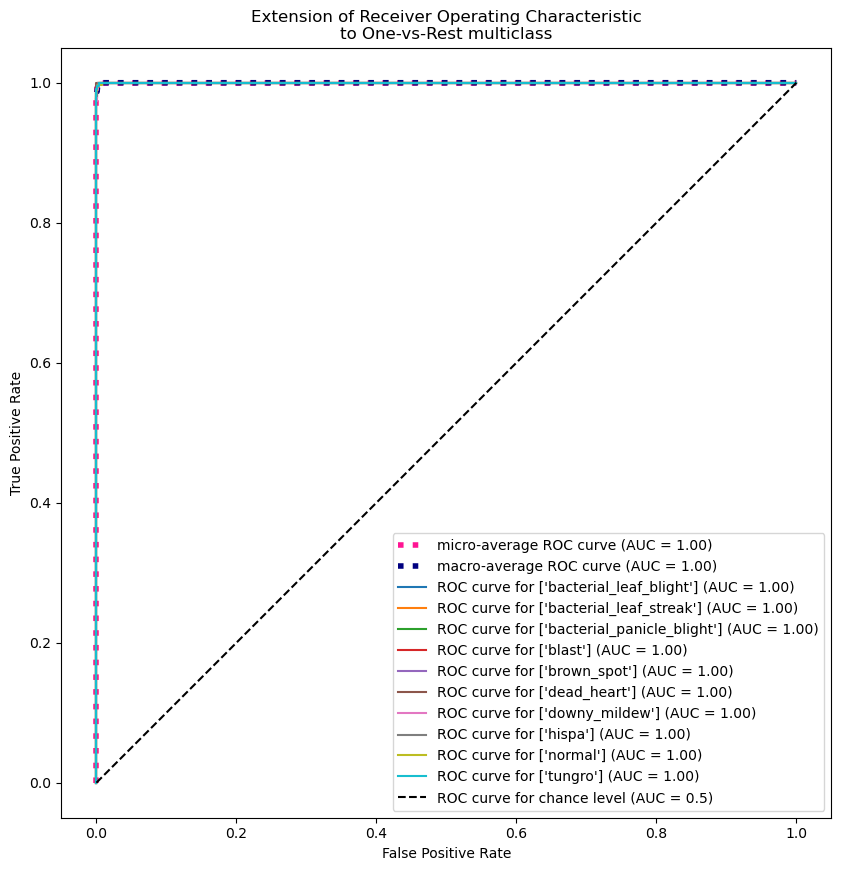

time: 430 ms (started: 2023-05-01 10:27:39 +00:00)


In [15]:
ROC(y_onehot_test, y_score, dls, 10)

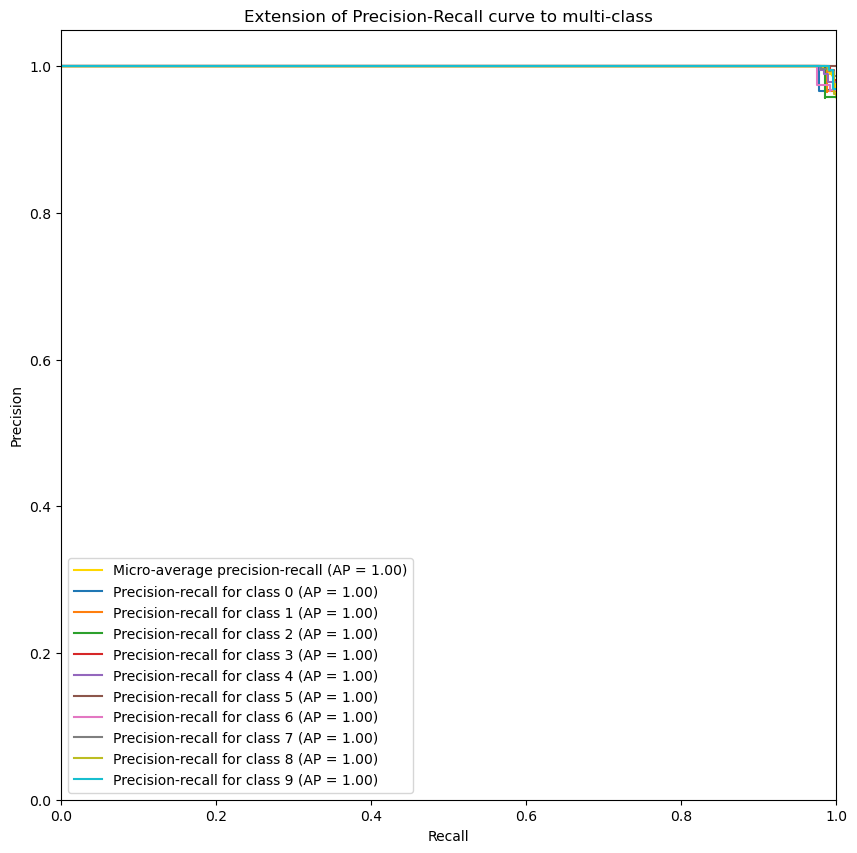

time: 375 ms (started: 2023-05-01 10:27:40 +00:00)


In [16]:
PRC(y_onehot_test, y_score, n_classes=10)

In [17]:
interpret = ClassificationInterpretation.from_learner(learner, dl=tst_dl)

time: 1min 50s (started: 2023-05-01 10:27:40 +00:00)


In [18]:
interpret.print_classification_report()

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.96      0.89      0.92        96
   bacterial_leaf_streak       0.86      0.96      0.91        76
bacterial_panicle_blight       0.88      0.88      0.88        68
                   blast       0.92      0.96      0.94       348
              brown_spot       0.94      0.90      0.92       193
              dead_heart       0.97      0.96      0.96       289
            downy_mildew       0.86      0.82      0.84       124
                   hispa       0.96      0.93      0.94       319
                  normal       0.93      0.95      0.94       353
                  tungro       0.90      0.92      0.91       218

                accuracy                           0.93      2084
               macro avg       0.92      0.92      0.92      2084
            weighted avg       0.93      0.93      0.93      2084

time: 2min 17s (started: 2023-05-01 10:29:30 +00:00)


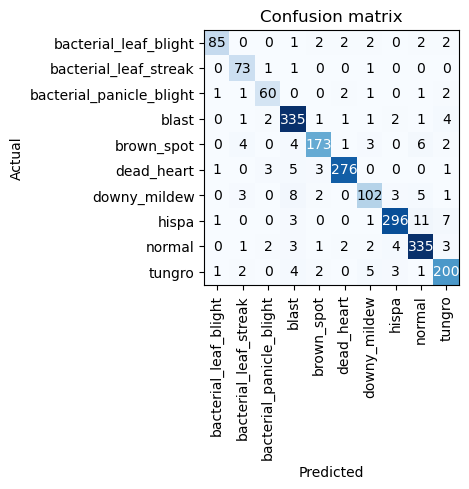

time: 2min 16s (started: 2023-05-01 10:31:48 +00:00)


In [19]:
interpret.plot_confusion_matrix()

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

time: 1.11 ms (started: 2023-05-01 10:34:04 +00:00)


In [21]:
count_parameters(learn.model)


134309962

time: 6.09 ms (started: 2023-05-01 10:34:04 +00:00)


In [22]:
pruner = Pruner()
pruned_model = pruner.prune_model(learn.model)

time: 87.5 ms (started: 2023-05-01 10:34:04 +00:00)


In [23]:
pruned_learn = Learner(dls, pruned_model.cuda(), metrics=accuracy)


time: 3.06 ms (started: 2023-05-01 10:34:04 +00:00)


In [24]:
pruned_learn.validate()

(#2) [0.26230815052986145,0.9264423251152039]

time: 31.1 s (started: 2023-05-01 10:34:04 +00:00)


In [25]:
count_parameters(pruned_learn)

102181178

time: 6.01 ms (started: 2023-05-01 10:34:35 +00:00)


In [27]:
pruned_learn.export(Path("/kaggle/working/VGG16_bn_native_fp16_accum2_sparse25_pruned.pkl"))

time: 1.62 s (started: 2023-05-01 10:35:19 +00:00)
